In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = True
plot_dir = '../plots/plots_2021-01-17'
save_tag = 'xordmax0_mordmax1_rbins1'

#r_edges = np.logspace(np.log10(1), np.log10(1000), 4) 
r_edges = np.array([0, 1000])
print(r_edges)

#l_arr = np.array([0, 1, 2, 3])
l_arr = np.array([0])

x_order_max = 0
m_order_max = 1

[   0 1000]


In [3]:
mass_multiplier = 1e10

In [4]:
featurizer = Featurizer(r_edges, l_arr)
featurizer.read_simulations()
featurizer.match_twins()
featurizer.select_halos()
featurizer.add_info_to_halo_dicts()

In [5]:
print(featurizer.N_halos)

2344


In [6]:
featurizer.compute_geometric_features()
featurizer.compute_scalar_features(x_order_max=x_order_max, m_order_max=m_order_max)
featurizer.set_y_labels()

In [7]:
print(featurizer.n_features)

2


In [8]:
fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                featurizer.x_scalar_dicts)
fitter.split_train_test()
fitter.scale_and_fit()

n_train: 1876, n_test: 468
n_parameters: 2
rank: 2
n_feat: 2


In [9]:
fitter.predict()

In [10]:
y_true = fitter.y_scalar_test*mass_multiplier
y_pred = fitter.y_scalar_pred*mass_multiplier
mse = np.mean((y_pred - y_true)**2)
print(f"Mean squared error: {mse:.3e}")

Mean squared error: 1.078e+19


In [11]:
print("In training set:")
print(f"Total number of halos: {fitter.n_train}")
print(f"Number of zero-stellar-mass halos: {fitter.n_train - np.count_nonzero(fitter.y_scalar_train)}")
print(f"Min/max stellar mass: {min(fitter.y_scalar_train)*mass_multiplier:.3e} / {max(fitter.y_scalar_train)*mass_multiplier:.3e}")
print(f"Minimum nonzero mass: {min(fitter.y_scalar_train[np.nonzero(fitter.y_scalar_train)[0]])*mass_multiplier:.3e}")

In training set:
Total number of halos: 1876
Number of zero-stellar-mass halos: 0
Min/max stellar mass: 4.349e+06 / 1.387e+12
Minimum nonzero mass: 4.349e+06


In [12]:
print("In test set:")
print(f"Total number of halos: {fitter.n_test}")
print(f"Number of zero-stellar-mass halos: {fitter.n_test - np.count_nonzero(fitter.y_scalar_test)}")
print(f"Min/max stellar mass: {min(fitter.y_scalar_test)*mass_multiplier:.3e} / {max(fitter.y_scalar_test)*mass_multiplier:.3e}")
print(f"Minimum nonzero mass: {min(fitter.y_scalar_test[np.nonzero(fitter.y_scalar_test)[0]])*mass_multiplier:.3e}")
print()
print(f"Minimum nonzero predicted mass: {min(fitter.y_scalar_pred[np.nonzero(fitter.y_scalar_pred)[0]])*mass_multiplier:.3e}")
print(f"Minimum positive predicted mass: {min(fitter.y_scalar_pred[np.where(fitter.y_scalar_pred > 0)[0]])*mass_multiplier:.3e}")
print(f"Number mass predictions with m<0:", len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0]))
print(f"Number mass predictions with |m|<1e5:", len(np.where(abs(fitter.y_scalar_pred*mass_multiplier) < 1e5)[0]))

In test set:
Total number of halos: 468
Number of zero-stellar-mass halos: 0
Min/max stellar mass: 6.473e+06 / 1.043e+11
Minimum nonzero mass: 6.473e+06

Minimum nonzero predicted mass: -3.817e+08
Minimum positive predicted mass: 1.520e+06
Number mass predictions with m<0: 50
Number mass predictions with |m|<1e5: 0


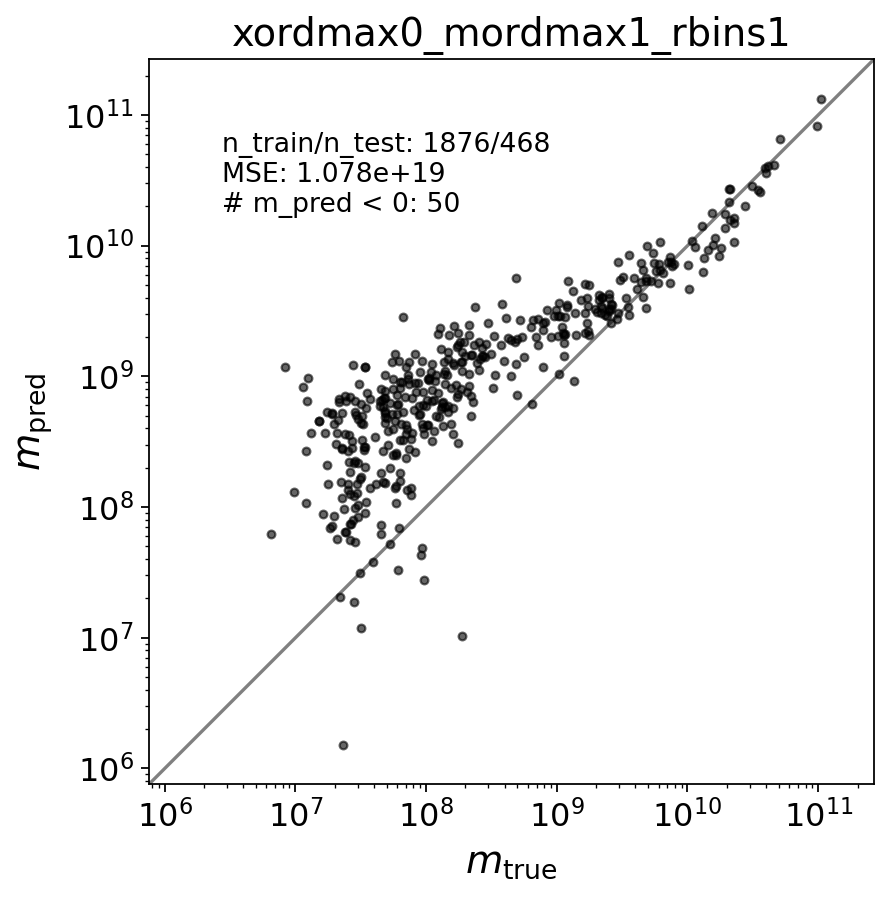

In [13]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
  
# main scatter plotting
plt.scatter(y_true, y_pred, s=12, alpha=0.6, c='k')

# get limits, plot true line
m_minmin = min(min(y_true[np.where(y_true > 0)]), 
               min(y_pred[np.where(y_pred > 0)]))
m_maxmax = max(max(y_true[np.where(y_true > 0)]), 
               max(y_pred[np.where(y_true > 0)]))
true_line = np.linspace(0.5*m_minmin, 2*m_maxmax)
plt.plot(true_line, true_line, color='grey', zorder=0)

# labels & adjustments
plt.xlabel(r'$m_\mathrm{true}$')
plt.ylabel(r'$m_\mathrm{pred}$')
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.xlim(0.5*m_minmin, 2*m_maxmax)
plt.ylim(0.5*m_minmin, 2*m_maxmax)

n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
plt.text(0.1, 0.9, f'n_train/n_test: {fitter.n_train}/{fitter.n_test} \nMSE: {mse:.3e} \n# m_pred < 0: {n_neg}', 
         transform=ax.transAxes, verticalalignment='top', fontsize=12)
plt.title(save_tag)

# save
save_fn = f'mass_recovery{save_tag}.pdf'
if save_plots:
      plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

(array([ 27., 378.,  51.,   8.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([-19.02765287,  -3.10801321,  12.81162645,  28.73126611,
         44.65090577,  60.57054543,  76.49018509,  92.40982475,
        108.32946441, 124.24910407, 140.16874373]),
 [<matplotlib.patches.Polygon at 0x14f9890e0b20>])

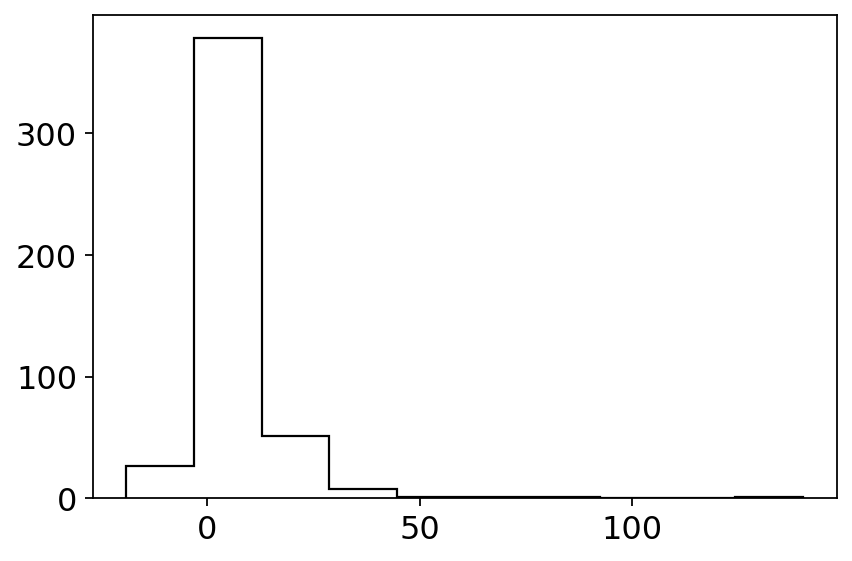

In [14]:
plt.hist((y_pred - y_true)/y_true, histtype='step', color='k')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  14., 299., 111.,
         26.,  11.,   2.,   1.,   0.,   2.,   0.,   0.]),
 array([-100.        ,  -89.47368421,  -78.94736842,  -68.42105263,
         -57.89473684,  -47.36842105,  -36.84210526,  -26.31578947,
         -15.78947368,   -5.26315789,    5.26315789,   15.78947368,
          26.31578947,   36.84210526,   47.36842105,   57.89473684,
          68.42105263,   78.94736842,   89.47368421,  100.        ]),
 [<matplotlib.patches.Polygon at 0x14f988a996a0>])

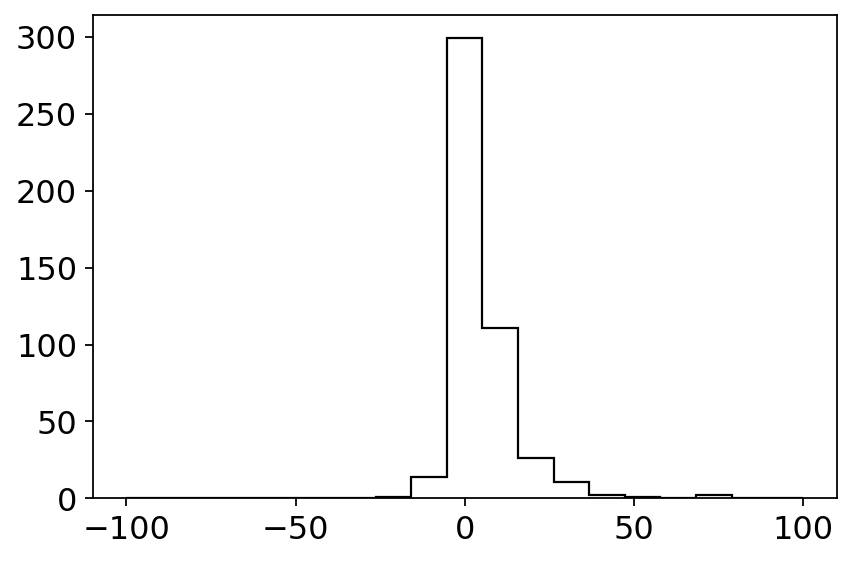

In [15]:
bins = np.linspace(-100, 100, 20)
plt.hist((y_pred - y_true)/y_true, bins=bins, histtype='step', color='k')

(array([  1.,   0.,   0.,   1.,   9., 168., 287.,   1.,   0.,   1.]),
 array([-4.31535714e+10, -3.59184170e+10, -2.86832626e+10, -2.14481082e+10,
        -1.42129538e+10, -6.97779945e+09,  2.57354939e+08,  7.49250933e+09,
         1.47276637e+10,  2.19628181e+10,  2.91979725e+10]),
 [<matplotlib.patches.Polygon at 0x14f988a6e820>])

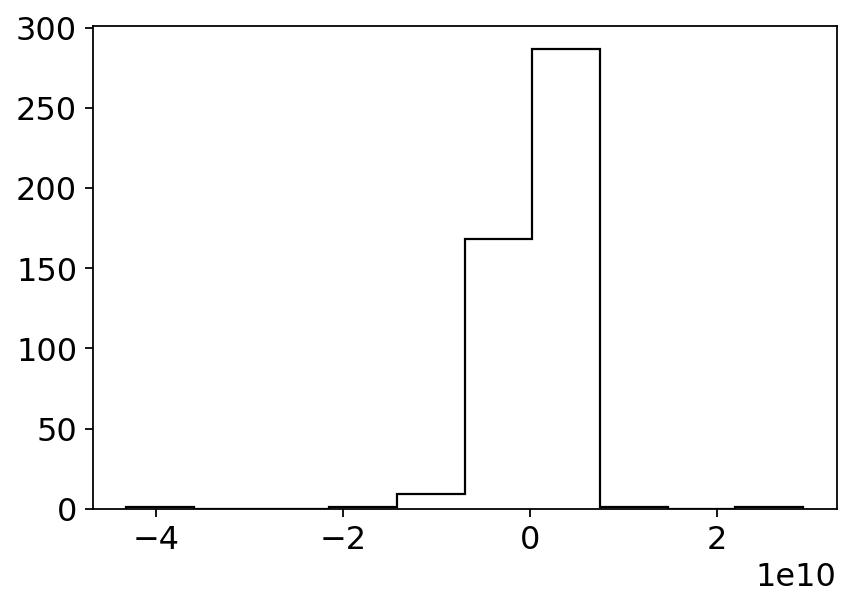

In [16]:
plt.hist((y_pred - y_true), histtype='step', color='k')